In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import numpy as np
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm_notebook as tqdm
from tensorflow.contrib import slim
from IPython import display

In [2]:
# graph = tf.Graph()
sess = tf.InteractiveSession()

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_labels = tf.one_hot(train_labels, depth=10).eval()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# # Binarization
# train_images[train_images >= .5] = 1.
# train_images[train_images < .5] = 0.
# test_images[test_images >= .5] = 1.
# test_images[test_images < .5] = 0.

In [5]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [6]:
def data_points_generator(images, batch_size=3):
    batchXC = []
    batchYC = []
    batchYT = []
    
    n_context_points = np.random.randint(1, 28*28)
    all_ids = np.arange(0, 28*28, 1, dtype=np.int32)
    x_t = np.dstack(np.unravel_index(all_ids, (28,28)))[0] / 28.0
    x_t = np.repeat(x_t[np.newaxis], batch_size, axis=0).astype(np.float32)

    for img in images:
        random_ids = np.random.choice(all_ids, n_context_points, replace=False)
        y_c = img[random_ids]
        x_c = np.dstack(np.unravel_index(random_ids, (28,28)))[0] / 28.0
        batchXC.append(x_c)
        batchYC.append(y_c)
        batchYT.append(img)
        if len(batchXC) == batch_size:
            yield np.array(batchXC, dtype=np.float32), np.array(batchYC, dtype=np.float32)[:,:,np.newaxis], \
                  x_t, np.array(batchYT, dtype=np.float32)[:,:,np.newaxis]
            batchXC = []
            batchYC = []
            batchYT = []
            n_context_points = np.random.randint(1, 28*28)

In [7]:
g = data_points_generator(train_images[:50])

In [8]:
xc, yc, xt, yt = g.next()

In [9]:
xc.shape, yc.shape, xt.shape, yt.shape

((3, 43, 2), (3, 43, 1), (3, 784, 2), (3, 784, 1))

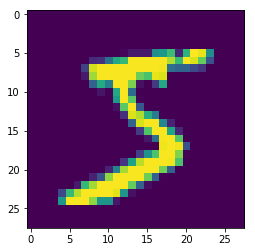

In [10]:
plt.imshow(yt[0,:,0].reshape(28,28))

In [11]:
import functools
train_generator = functools.partial(data_points_generator, train_images, 64)

In [12]:
ds = tf.data.Dataset.from_generator(train_generator, (tf.float32, tf.float32, tf.float32, tf.float32),
                                   (tf.TensorShape([None, None, 2]), tf.TensorShape([None, None, 1]),
                                    tf.TensorShape([None, None, 2]), tf.TensorShape([None, None, 1])))
data_iterator = ds.repeat().make_initializable_iterator()
context_x, context_y, target_x, target_y = data_iterator.get_next()

In [13]:
context_x, context_y, target_x, target_y 

(<tf.Tensor 'IteratorGetNext:0' shape=(?, ?, 2) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:2' shape=(?, ?, 2) dtype=float32>,
 <tf.Tensor 'IteratorGetNext:3' shape=(?, ?, 1) dtype=float32>)

In [21]:
def aggregator(r):
    return tf.reduce_mean(r, axis=1)

def encoder(x, y):
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        # x.shape = [bs, n_points, 2]
        # y.shape = [bs, n_points, 1]
        bs = tf.shape(x)[0]
        n_points = tf.shape(x)[1]
        x = tf.reshape(x, (bs*n_points, x.shape.as_list()[-1]))
        y = tf.reshape(y, (bs*n_points, y.shape.as_list()[-1]))
        x = tf.concat([x,y], axis=-1)
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        mu = slim.fully_connected(x, 64, activation_fn=None)
        sigma = slim.fully_connected(x, 64, activation_fn=tf.nn.softplus)
        
        mu = tf.reshape(mu, (bs,n_points, mu.shape.as_list()[-1]))
        sigma = tf.reshape(sigma, (bs,n_points,sigma.shape.as_list()[-1]))
        return aggregator(mu), aggregator(sigma)
    
def decoder(zc, xt):
    with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
        # zc.shape = [bs, z_dim]
        # xt.shape = [bs, n_points, 1]
        bs = tf.shape(xt)[0]
        n_points = tf.shape(xt)[1]
        zc = tf.tile(tf.expand_dims(zc, axis=1), [1, n_points, 1])
        x = tf.concat([zc, xt], axis=-1)
        x = tf.reshape(x, (bs*n_points, x.shape.as_list()[-1]))
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 1, activation_fn=None)
        x_probs = tf.nn.sigmoid(x)
        yt = tf.reshape(x, (bs, n_points, x.shape.as_list()[-1]))
#         yt_probs = tf.reshape(x_probs, (bs, n_points, x.shape.as_list()[-1]))
        return yt, tf.nn.sigmoid(yt)
    
    
class NP:
    
    def __init__(self, c_x, c_y, t_x=None, t_y=None):
        with tf.variable_scope('np', reuse=tf.AUTO_REUSE):
            
            self.c_x, self.c_y, self.t_x, self.t_y = c_x, c_y, t_x, t_y
            self.z_mu_c, self.z_sigma_c = encoder(c_x, c_y)
            self.q_z_c = tf.distributions.Normal(self.z_mu_c, self.z_sigma_c)
            
            if t_y is not None:
                self.z_mu_all, self.z_sigma_all = encoder(t_x, t_y)
                self.q_z_all = tf.distributions.Normal(self.z_mu_all, self.z_sigma_all)
                self.q_z_all_sample = self.q_z_all.sample()
                self.y_t_hat, self.y_t_hat_probs = decoder(self.q_z_all_sample, t_x)
            else:
                self.y_t_hat, self.y_t_hat_probs = decoder(self.q_z_c.sample(), t_x)
            
#             self.y_t_hat_distribution = tf.distributions.Bernoulli(logits=self.y_t_hat)
#             self.y_t_hat_sample = self.y_t_hat_distribution.sample()
            self._loss = None
        
    
    @property
    def loss(self):
        if self._loss is None:
            self.kl = tf.reduce_sum(tf.distributions.kl_divergence(self.q_z_c, self.q_z_all), axis=1)
#             self.log_likelihood = tf.reduce_sum(self.y_t_hat_distribution.log_prob(self.t_y), axis=1)
#             elbo = tf.reduce_mean(self.log_likelihood - self.kl)
#             self._loss = -elbo
            self.binary_crossentropy = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.y_t_hat, labels=self.t_y), axis=1)
            self._loss = tf.reduce_mean(self.binary_crossentropy + self.kl)
        return self._loss
    
        

In [22]:
net = NP(context_x, context_y, target_x, target_y)

In [23]:
with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
    train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(net.loss)

In [24]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [25]:
sess.run(data_iterator.initializer) 

In [322]:
epochs = 20
for epoch in range(1, epochs + 1):
    start_time = time.time()
    all_elbos = []
    all_kl = []
    all_logl = []
    cnt = 0
    try:
        for i in tqdm(range(60000/64)):
            _, elbo_value, kl, logl = sess.run([train_op, net.loss, net.kl, net.binary_crossentropy])
            all_elbos.append(elbo_value)
            all_kl.append(kl)
            all_logl.append(logl)
            cnt +=1
    except tf.errors.OutOfRangeError:
        pass
        
    end_time = time.time()

#     display.clear_output(wait=False)
    print('Epoch: {}, ELBO: {},  KL: {}, LogLikelihood: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    np.mean(all_elbos), np.mean(all_kl), np.mean(all_logl),
                                                    end_time - start_time))
    
    all_elbos = []

Epoch: 1, ELBO: 134.916442871,  KL: 8.86538791656, LogLikelihood: 126.051063538, time elapse for current epoch 23.3151650429


Epoch: 2, ELBO: 134.257873535,  KL: 10.0186672211, LogLikelihood: 124.239196777, time elapse for current epoch 23.0900380611


Epoch: 3, ELBO: 136.579818726,  KL: 10.6399002075, LogLikelihood: 125.939926147, time elapse for current epoch 23.0017840862


Epoch: 4, ELBO: 136.105117798,  KL: 10.6420040131, LogLikelihood: 125.463119507, time elapse for current epoch 23.1527571678


Epoch: 5, ELBO: 138.38571167,  KL: 11.5766172409, LogLikelihood: 126.80909729, time elapse for current epoch 23.0798270702


Epoch: 6, ELBO: 134.704315186,  KL: 10.5488357544, LogLikelihood: 124.155464172, time elapse for current epoch 23.2958769798


Epoch: 7, ELBO: 140.379165649,  KL: 12.2493362427, LogLikelihood: 128.129837036, time elapse for current epoch 23.0803530216


Epoch: 8, ELBO: 137.602783203,  KL: 11.7283058167, LogLikelihood: 125.874481201, time elapse for current epoch 23.0500240326


Epoch: 9, ELBO: 136.677307129,  KL: 11.7396469116, LogLikelihood: 124.937667847, time elapse for current epoch 23.3056080341


Epoch: 10, ELBO: 134.465942383,  KL: 10.6838121414, LogLikelihood: 123.78212738, time elapse for current epoch 22.8972139359


Epoch: 11, ELBO: 136.281799316,  KL: 11.0257387161, LogLikelihood: 125.256065369, time elapse for current epoch 23.3830280304


Epoch: 12, ELBO: 133.114898682,  KL: 10.9845085144, LogLikelihood: 122.130378723, time elapse for current epoch 22.9067831039


Epoch: 13, ELBO: 140.610412598,  KL: 13.6356010437, LogLikelihood: 126.974815369, time elapse for current epoch 22.808743


Epoch: 14, ELBO: 141.997833252,  KL: 15.8725986481, LogLikelihood: 126.125228882, time elapse for current epoch 23.0325241089


Epoch: 15, ELBO: 135.834625244,  KL: 10.1141090393, LogLikelihood: 125.720527649, time elapse for current epoch 23.145663023


Epoch: 16, ELBO: 140.966033936,  KL: 14.1249485016, LogLikelihood: 126.841079712, time elapse for current epoch 23.0348761082


Epoch: 17, ELBO: 131.425247192,  KL: 10.2278404236, LogLikelihood: 121.197410583, time elapse for current epoch 23.2104101181


Epoch: 18, ELBO: 133.897857666,  KL: 11.7817869186, LogLikelihood: 122.116073608, time elapse for current epoch 22.7768280506


Epoch: 19, ELBO: 133.529678345,  KL: 11.8234434128, LogLikelihood: 121.706245422, time elapse for current epoch 22.7186980247


Epoch: 20, ELBO: 134.84085083,  KL: 12.266453743, LogLikelihood: 122.574394226, time elapse for current epoch 23.077259779


In [27]:
test_context_x = tf.placeholder(dtype=np.float32, shape=(1, None, 2))
test_context_y = tf.placeholder(dtype=np.float32, shape=(1, None, 1))
test_target_x = tf.placeholder(dtype=np.float32, shape=(1, 28*28, 2))

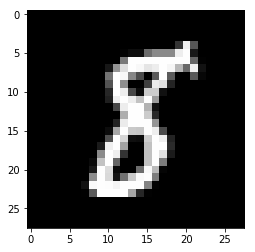

((1, 784, 2), (1, 784, 1), (1, 150, 2), (1, 150, 1))

In [319]:
import random

sample_id = random.randint(0,1000)
img = train_images[sample_id].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()

all_ids = np.arange(0, 28*28, 1, dtype=np.int32)
x_t = np.dstack(np.unravel_index(all_ids, (28,28)))[0] / 28.0
x_t = x_t[np.newaxis]
y_t = train_images[idx][np.newaxis,:,np.newaxis]




x_t.shape, y_t.shape, x_c.shape, y_c.shape

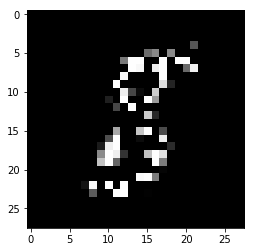

In [320]:
n_context_points = 350
random_ids = np.random.choice(all_ids, n_context_points, replace=False)
y_c = train_images[sample_id][random_ids][np.newaxis,:, np.newaxis]
x_c = np.dstack(np.unravel_index(random_ids, (28,28)))[0] / 28.0
x_c = x_c[np.newaxis]

vis_y_c = np.zeros((28,28), dtype=np.float32)
for i, (idx,idy) in enumerate((x_c*28).astype(np.int32)[0]):
    vis_y_c[idx,idy] = y_c[0,i,0]
plt.imshow(vis_y_c, cmap='gray')

In [49]:
test_net = NP(test_context_x, test_context_y, test_target_x, None)

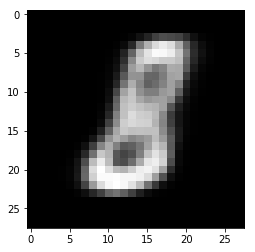

In [321]:
img_res = sess.run(test_net.y_t_hat_probs, 
                   feed_dict={test_context_x: x_c, test_context_y: y_c, test_target_x: x_t})[0,:,0]
plt.imshow(img_res.reshape(28,28), cmap='gray')